In [1]:
import pandas as pd
from tqdm.notebook import tqdm, trange
import torch
from torch.utils.data import DataLoader
import numpy as np
import torchvision
import random
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 160
EPOCHS = 51
BATCH_SIZE = 64
LEARNING_RATE = 0.001

SEED = 69
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.random.manual_seed(SEED)
torch.cuda.random.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
device = torch.device(device)

train_type_dir = '../data/train/type'
train_nrj_dir = '../data/train/nrj'
test_dir = '../data/test/'

cuda


In [3]:
train_transforms = transforms.Compose([transforms.CenterCrop(RESCALE_SIZE), 
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomVerticalFlip(p=0.5),
                                       transforms.RandomRotation(45),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])
                                       ])

testval_transforms = transforms.Compose([transforms.CenterCrop(RESCALE_SIZE),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           [0.485, 0.456, 0.406],
                                           [0.229, 0.224, 0.225])
                                       ])

In [4]:
def load_split_train_valid(datadir, batch_size, train_transforms, valid_transforms, valid_size):

    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    val_data = datasets.ImageFolder(datadir, transform=testval_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, val_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    trainloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    valloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)   

    return trainloader, valloader

In [5]:
test_dataset = torchvision.datasets.ImageFolder(test_dir, testval_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)
len(test_loader), len(test_dataset)

(259, 16560)

In [6]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.random.manual_seed(seed)
    torch.cuda.random.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [7]:
def train_model(model, loss, optimizer, scheduler, num_epochs, train_dataloader, val_dataloader):
    hystory_loss_train = []
    hystory_loss_val = []

    hystory_acc_train = []
    hystory_acc_val = []  
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader                
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                
                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            if phase == 'train':
                hystory_loss_train.append(epoch_loss)
                hystory_acc_train.append(epoch_acc)
                scheduler.step()
            else:
                hystory_loss_val.append(epoch_loss)
                hystory_acc_val.append(epoch_acc)


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return hystory_loss_train, hystory_loss_val, hystory_acc_train, hystory_acc_val

In [8]:
class CNNc2(nn.Module): 
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.drop1 = nn.Dropout2d(p=0.25)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.drop2 = nn.Dropout2d(p=0.25)
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.drop3 = nn.Dropout2d(p=0.25)
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(8192, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.out = nn.Linear(1024, 2)
    
    def forward(self, x):
        x = self.drop1(self.conv1(x))
        x = self.drop2(self.conv2(x))
        x = self.drop3(self.conv3(x))
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        
        return F.log_softmax(x, dim=1)

Epoch 0/50:



train Loss: 0.5862 Acc: 0.7473



val Loss: 0.1045 Acc: 0.9799
Epoch 1/50:



train Loss: 0.0801 Acc: 0.9738



val Loss: 0.0433 Acc: 0.9896
Epoch 2/50:



train Loss: 0.0531 Acc: 0.9848



val Loss: 0.0062 Acc: 0.9989
Epoch 3/50:



train Loss: 0.0412 Acc: 0.9889



val Loss: 0.0052 Acc: 0.9989
Epoch 4/50:



train Loss: 0.0350 Acc: 0.9901



val Loss: 0.0062 Acc: 0.9989
Epoch 5/50:



train Loss: 0.0389 Acc: 0.9882



val Loss: 0.0041 Acc: 0.9996
Epoch 6/50:



train Loss: 0.0267 Acc: 0.9921



val Loss: 0.0069 Acc: 0.9981
Epoch 7/50:



train Loss: 0.0213 Acc: 0.9949



val Loss: 0.0029 Acc: 0.9996
Epoch 8/50:



train Loss: 0.0207 Acc: 0.9947



val Loss: 0.0021 Acc: 0.9996
Epoch 9/50:



train Loss: 0.0154 Acc: 0.9955



val Loss: 0.0015 Acc: 0.9996
Epoch 10/50:



train Loss: 0.0262 Acc: 0.9921



val Loss: 0.0020 Acc: 0.9996
Epoch 11/50:



train Loss: 0.0231 Acc: 0.9931



val Loss: 0.0034 Acc: 0.9993
Epoch 12/50:



train Loss: 0.0156 Acc: 0.9954



val Loss: 0.0020 Acc: 0.9996
Epoch 13/50:



train Loss: 0.0138 Acc: 0.9960



val Loss: 0.0032 Acc: 0.9993
Epoch 14/50:



train Loss: 0.0187 Acc: 0.9942



val Loss: 0.0069 Acc: 0.9974
Epoch 15/50:



train Loss: 0.0136 Acc: 0.9966



val Loss: 0.0034 Acc: 0.9993
Epoch 16/50:



train Loss: 0.0175 Acc: 0.9946



val Loss: 0.0017 Acc: 0.9996
Epoch 17/50:



train Loss: 0.0171 Acc: 0.9949



val Loss: 0.0029 Acc: 0.9989
Epoch 18/50:



train Loss: 0.0125 Acc: 0.9965



val Loss: 0.0017 Acc: 0.9996
Epoch 19/50:



train Loss: 0.0139 Acc: 0.9948



val Loss: 0.0021 Acc: 0.9993
Epoch 20/50:



train Loss: 0.0128 Acc: 0.9966



val Loss: 0.0015 Acc: 0.9996
Epoch 21/50:



train Loss: 0.0127 Acc: 0.9961



val Loss: 0.0018 Acc: 0.9996
Epoch 22/50:



train Loss: 0.0123 Acc: 0.9963



val Loss: 0.0016 Acc: 0.9996
Epoch 23/50:



train Loss: 0.0134 Acc: 0.9957



val Loss: 0.0012 Acc: 0.9996
Epoch 24/50:



train Loss: 0.0114 Acc: 0.9971



val Loss: 0.0012 Acc: 0.9996
Epoch 25/50:



train Loss: 0.0112 Acc: 0.9964



val Loss: 0.0016 Acc: 0.9996
Epoch 26/50:



train Loss: 0.0127 Acc: 0.9966



val Loss: 0.0017 Acc: 0.9996
Epoch 27/50:



train Loss: 0.0106 Acc: 0.9967



val Loss: 0.0011 Acc: 0.9996
Epoch 28/50:



train Loss: 0.0106 Acc: 0.9975



val Loss: 0.0012 Acc: 0.9996
Epoch 29/50:



train Loss: 0.0099 Acc: 0.9969



val Loss: 0.0013 Acc: 0.9996
Epoch 30/50:



train Loss: 0.0102 Acc: 0.9971



val Loss: 0.0012 Acc: 0.9996
Epoch 31/50:



train Loss: 0.0108 Acc: 0.9967



val Loss: 0.0012 Acc: 0.9996
Epoch 32/50:



train Loss: 0.0098 Acc: 0.9967



val Loss: 0.0011 Acc: 0.9996
Epoch 33/50:



train Loss: 0.0107 Acc: 0.9968



val Loss: 0.0012 Acc: 0.9996
Epoch 34/50:



train Loss: 0.0091 Acc: 0.9975



val Loss: 0.0015 Acc: 0.9996
Epoch 35/50:



train Loss: 0.0096 Acc: 0.9972



val Loss: 0.0012 Acc: 0.9996
Epoch 36/50:



train Loss: 0.0106 Acc: 0.9973



val Loss: 0.0012 Acc: 0.9996
Epoch 37/50:



train Loss: 0.0106 Acc: 0.9970



val Loss: 0.0011 Acc: 0.9996
Epoch 38/50:



train Loss: 0.0105 Acc: 0.9966



val Loss: 0.0011 Acc: 0.9996
Epoch 39/50:



train Loss: 0.0094 Acc: 0.9972



val Loss: 0.0013 Acc: 0.9996
Epoch 40/50:



train Loss: 0.0106 Acc: 0.9965



val Loss: 0.0012 Acc: 0.9996
Epoch 41/50:



train Loss: 0.0087 Acc: 0.9974



val Loss: 0.0011 Acc: 0.9996
Epoch 42/50:



train Loss: 0.0088 Acc: 0.9976



val Loss: 0.0010 Acc: 0.9996
Epoch 43/50:



train Loss: 0.0097 Acc: 0.9968



val Loss: 0.0010 Acc: 0.9996
Epoch 44/50:



train Loss: 0.0089 Acc: 0.9971



val Loss: 0.0011 Acc: 0.9996
Epoch 45/50:



train Loss: 0.0082 Acc: 0.9975



val Loss: 0.0010 Acc: 0.9996
Epoch 46/50:



train Loss: 0.0094 Acc: 0.9977



val Loss: 0.0011 Acc: 0.9996
Epoch 47/50:



train Loss: 0.0100 Acc: 0.9969



val Loss: 0.0010 Acc: 0.9996
Epoch 48/50:



train Loss: 0.0076 Acc: 0.9981



val Loss: 0.0010 Acc: 0.9996
Epoch 49/50:



train Loss: 0.0097 Acc: 0.9969



val Loss: 0.0011 Acc: 0.9996
Epoch 50/50:



train Loss: 0.0102 Acc: 0.9968



val Loss: 0.0010 Acc: 0.9996



Epoch 0/50:



train Loss: 0.5499 Acc: 0.7712



val Loss: 0.0366 Acc: 0.9952
Epoch 1/50:



train Loss: 0.0785 Acc: 0.9754



val Loss: 0.0264 Acc: 0.9937
Epoch 2/50:



train Loss: 0.0490 Acc: 0.9847



val Loss: 0.0194 Acc: 0.9955
Epoch 3/50:



train Loss: 0.0384 Acc: 0.9880



val Loss: 0.0117 Acc: 0.9970
Epoch 4/50:



train Loss: 0.0351 Acc: 0.9914



val Loss: 0.0153 Acc: 0.9959
Epoch 5/50:



train Loss: 0.0322 Acc: 0.9912



val Loss: 0.0080 Acc: 0.9981
Epoch 6/50:



train Loss: 0.0267 Acc: 0.9926



val Loss: 0.0076 Acc: 0.9978
Epoch 7/50:



train Loss: 0.0182 Acc: 0.9946



val Loss: 0.0056 Acc: 0.9985
Epoch 8/50:



train Loss: 0.0209 Acc: 0.9943



val Loss: 0.0041 Acc: 0.9993
Epoch 9/50:



train Loss: 0.0184 Acc: 0.9940



val Loss: 0.0032 Acc: 0.9993
Epoch 10/50:



train Loss: 0.0222 Acc: 0.9941



val Loss: 0.0035 Acc: 0.9993
Epoch 11/50:



train Loss: 0.0157 Acc: 0.9952



val Loss: 0.0046 Acc: 0.9989
Epoch 12/50:



train Loss: 0.0130 Acc: 0.9965



val Loss: 0.0035 Acc: 0.9989
Epoch 13/50:



train Loss: 0.0132 Acc: 0.9965



val Loss: 0.0036 Acc: 0.9993
Epoch 14/50:



train Loss: 0.0140 Acc: 0.9968



val Loss: 0.0041 Acc: 0.9985
Epoch 15/50:



train Loss: 0.0135 Acc: 0.9962



val Loss: 0.0033 Acc: 0.9993
Epoch 16/50:



train Loss: 0.0127 Acc: 0.9969



val Loss: 0.0039 Acc: 0.9989
Epoch 17/50:



train Loss: 0.0125 Acc: 0.9962



val Loss: 0.0038 Acc: 0.9981
Epoch 18/50:



train Loss: 0.0126 Acc: 0.9970



val Loss: 0.0033 Acc: 0.9993
Epoch 19/50:



train Loss: 0.0126 Acc: 0.9969



val Loss: 0.0027 Acc: 0.9996
Epoch 20/50:



train Loss: 0.0094 Acc: 0.9971



val Loss: 0.0026 Acc: 0.9996
Epoch 21/50:



train Loss: 0.0105 Acc: 0.9974



val Loss: 0.0035 Acc: 0.9985
Epoch 22/50:



train Loss: 0.0101 Acc: 0.9970



val Loss: 0.0044 Acc: 0.9985
Epoch 23/50:



train Loss: 0.0105 Acc: 0.9968



val Loss: 0.0024 Acc: 0.9993
Epoch 24/50:



train Loss: 0.0105 Acc: 0.9965



val Loss: 0.0022 Acc: 0.9993
Epoch 25/50:



train Loss: 0.0115 Acc: 0.9966



val Loss: 0.0025 Acc: 0.9993
Epoch 26/50:



train Loss: 0.0086 Acc: 0.9976



val Loss: 0.0018 Acc: 0.9996
Epoch 27/50:



train Loss: 0.0097 Acc: 0.9977



val Loss: 0.0026 Acc: 0.9989
Epoch 28/50:



train Loss: 0.0098 Acc: 0.9973



val Loss: 0.0028 Acc: 0.9993
Epoch 29/50:



train Loss: 0.0092 Acc: 0.9976



val Loss: 0.0038 Acc: 0.9989
Epoch 30/50:



train Loss: 0.0096 Acc: 0.9971



val Loss: 0.0024 Acc: 0.9996
Epoch 31/50:



train Loss: 0.0118 Acc: 0.9970



val Loss: 0.0020 Acc: 0.9996
Epoch 32/50:



train Loss: 0.0095 Acc: 0.9975



val Loss: 0.0016 Acc: 0.9996
Epoch 33/50:



train Loss: 0.0087 Acc: 0.9977



val Loss: 0.0027 Acc: 0.9993
Epoch 34/50:



train Loss: 0.0071 Acc: 0.9983



val Loss: 0.0023 Acc: 0.9993
Epoch 35/50:



train Loss: 0.0082 Acc: 0.9980



val Loss: 0.0035 Acc: 0.9989
Epoch 36/50:



train Loss: 0.0088 Acc: 0.9978



val Loss: 0.0028 Acc: 0.9993
Epoch 37/50:



train Loss: 0.0104 Acc: 0.9973



val Loss: 0.0027 Acc: 0.9993
Epoch 38/50:



train Loss: 0.0069 Acc: 0.9982



val Loss: 0.0028 Acc: 0.9993
Epoch 39/50:



train Loss: 0.0077 Acc: 0.9979



val Loss: 0.0028 Acc: 0.9993
Epoch 40/50:



train Loss: 0.0084 Acc: 0.9977



val Loss: 0.0034 Acc: 0.9985
Epoch 41/50:



train Loss: 0.0090 Acc: 0.9976



val Loss: 0.0033 Acc: 0.9985
Epoch 42/50:



train Loss: 0.0076 Acc: 0.9980



val Loss: 0.0031 Acc: 0.9993
Epoch 43/50:



train Loss: 0.0094 Acc: 0.9975



val Loss: 0.0028 Acc: 0.9989
Epoch 44/50:



train Loss: 0.0066 Acc: 0.9983



val Loss: 0.0030 Acc: 0.9989
Epoch 45/50:



train Loss: 0.0087 Acc: 0.9978



val Loss: 0.0024 Acc: 0.9993
Epoch 46/50:



train Loss: 0.0085 Acc: 0.9972



val Loss: 0.0024 Acc: 0.9993
Epoch 47/50:



train Loss: 0.0091 Acc: 0.9976



val Loss: 0.0028 Acc: 0.9989
Epoch 48/50:



train Loss: 0.0069 Acc: 0.9976



val Loss: 0.0026 Acc: 0.9993
Epoch 49/50:



train Loss: 0.0075 Acc: 0.9976



val Loss: 0.0028 Acc: 0.9989
Epoch 50/50:



train Loss: 0.0078 Acc: 0.9975



val Loss: 0.0026 Acc: 0.9993



Epoch 0/50:



train Loss: 0.4289 Acc: 0.8133



val Loss: 0.0408 Acc: 0.9926
Epoch 1/50:



train Loss: 0.0735 Acc: 0.9763



val Loss: 0.0311 Acc: 0.9918
Epoch 2/50:



train Loss: 0.0442 Acc: 0.9856



val Loss: 0.0172 Acc: 0.9967
Epoch 3/50:



train Loss: 0.0329 Acc: 0.9903



val Loss: 0.0203 Acc: 0.9955
Epoch 4/50:



train Loss: 0.0490 Acc: 0.9847



val Loss: 0.0232 Acc: 0.9944
Epoch 5/50:



train Loss: 0.0262 Acc: 0.9927



val Loss: 0.0247 Acc: 0.9952
Epoch 6/50:



train Loss: 0.0252 Acc: 0.9923



val Loss: 0.0128 Acc: 0.9978
Epoch 7/50:



train Loss: 0.0225 Acc: 0.9930



val Loss: 0.0120 Acc: 0.9978
Epoch 8/50:



train Loss: 0.0226 Acc: 0.9922



val Loss: 0.0123 Acc: 0.9985
Epoch 9/50:



train Loss: 0.0200 Acc: 0.9938



val Loss: 0.0127 Acc: 0.9981
Epoch 10/50:



train Loss: 0.0161 Acc: 0.9956



val Loss: 0.0123 Acc: 0.9981
Epoch 11/50:



train Loss: 0.0195 Acc: 0.9951



val Loss: 0.0132 Acc: 0.9978
Epoch 12/50:



train Loss: 0.0153 Acc: 0.9960



val Loss: 0.0123 Acc: 0.9981
Epoch 13/50:



train Loss: 0.0145 Acc: 0.9952



val Loss: 0.0095 Acc: 0.9989
Epoch 14/50:



train Loss: 0.0115 Acc: 0.9973



val Loss: 0.0109 Acc: 0.9978
Epoch 15/50:



train Loss: 0.0117 Acc: 0.9968



val Loss: 0.0069 Acc: 0.9989
Epoch 16/50:



train Loss: 0.0145 Acc: 0.9960



val Loss: 0.0072 Acc: 0.9985
Epoch 17/50:



train Loss: 0.0143 Acc: 0.9958



val Loss: 0.0077 Acc: 0.9989
Epoch 18/50:



train Loss: 0.0131 Acc: 0.9960



val Loss: 0.0076 Acc: 0.9989
Epoch 19/50:



train Loss: 0.0095 Acc: 0.9977



val Loss: 0.0082 Acc: 0.9989
Epoch 20/50:



train Loss: 0.0119 Acc: 0.9974



val Loss: 0.0101 Acc: 0.9985
Epoch 21/50:



train Loss: 0.0117 Acc: 0.9962



val Loss: 0.0084 Acc: 0.9985
Epoch 22/50:



train Loss: 0.0093 Acc: 0.9973



val Loss: 0.0086 Acc: 0.9989
Epoch 23/50:



train Loss: 0.0096 Acc: 0.9969



val Loss: 0.0079 Acc: 0.9989
Epoch 24/50:



train Loss: 0.0093 Acc: 0.9971



val Loss: 0.0079 Acc: 0.9989
Epoch 25/50:



train Loss: 0.0079 Acc: 0.9981



val Loss: 0.0072 Acc: 0.9989
Epoch 26/50:



train Loss: 0.0107 Acc: 0.9976



val Loss: 0.0093 Acc: 0.9989
Epoch 27/50:



train Loss: 0.0067 Acc: 0.9982



val Loss: 0.0077 Acc: 0.9989
Epoch 28/50:



train Loss: 0.0074 Acc: 0.9976



val Loss: 0.0082 Acc: 0.9989
Epoch 29/50:



train Loss: 0.0090 Acc: 0.9980



val Loss: 0.0083 Acc: 0.9989
Epoch 30/50:



train Loss: 0.0076 Acc: 0.9977



val Loss: 0.0077 Acc: 0.9989
Epoch 31/50:



train Loss: 0.0078 Acc: 0.9976



val Loss: 0.0073 Acc: 0.9989
Epoch 32/50:



train Loss: 0.0082 Acc: 0.9972



val Loss: 0.0082 Acc: 0.9989
Epoch 33/50:



train Loss: 0.0097 Acc: 0.9973



val Loss: 0.0078 Acc: 0.9989
Epoch 34/50:



train Loss: 0.0102 Acc: 0.9968



val Loss: 0.0082 Acc: 0.9989
Epoch 35/50:



train Loss: 0.0086 Acc: 0.9973



val Loss: 0.0073 Acc: 0.9989
Epoch 36/50:



train Loss: 0.0094 Acc: 0.9977



val Loss: 0.0079 Acc: 0.9989
Epoch 37/50:



train Loss: 0.0081 Acc: 0.9974



val Loss: 0.0074 Acc: 0.9989
Epoch 38/50:



train Loss: 0.0073 Acc: 0.9979



val Loss: 0.0067 Acc: 0.9989
Epoch 39/50:



train Loss: 0.0070 Acc: 0.9982



val Loss: 0.0073 Acc: 0.9989
Epoch 40/50:



train Loss: 0.0089 Acc: 0.9980



val Loss: 0.0075 Acc: 0.9989
Epoch 41/50:



train Loss: 0.0071 Acc: 0.9983



val Loss: 0.0073 Acc: 0.9989
Epoch 42/50:



train Loss: 0.0067 Acc: 0.9976



val Loss: 0.0075 Acc: 0.9989
Epoch 43/50:



train Loss: 0.0059 Acc: 0.9983



val Loss: 0.0071 Acc: 0.9989
Epoch 44/50:



train Loss: 0.0071 Acc: 0.9983



val Loss: 0.0072 Acc: 0.9989
Epoch 45/50:



train Loss: 0.0077 Acc: 0.9979



val Loss: 0.0074 Acc: 0.9989
Epoch 46/50:



train Loss: 0.0083 Acc: 0.9976



val Loss: 0.0074 Acc: 0.9989
Epoch 47/50:



train Loss: 0.0083 Acc: 0.9973



val Loss: 0.0075 Acc: 0.9989
Epoch 48/50:



train Loss: 0.0068 Acc: 0.9976



val Loss: 0.0072 Acc: 0.9989
Epoch 49/50:



train Loss: 0.0077 Acc: 0.9982



val Loss: 0.0071 Acc: 0.9989
Epoch 50/50:



train Loss: 0.0079 Acc: 0.9975



val Loss: 0.0071 Acc: 0.9989



Epoch 0/50:



train Loss: 0.5176 Acc: 0.7761



val Loss: 0.0541 Acc: 0.9840
Epoch 1/50:



train Loss: 0.0699 Acc: 0.9792



val Loss: 0.0213 Acc: 0.9978
Epoch 2/50:



train Loss: 0.0510 Acc: 0.9841



val Loss: 0.0434 Acc: 0.9933
Epoch 3/50:



train Loss: 0.0447 Acc: 0.9867



val Loss: 0.0215 Acc: 0.9970
Epoch 4/50:



train Loss: 0.0367 Acc: 0.9897



val Loss: 0.0120 Acc: 0.9989
Epoch 5/50:



train Loss: 0.0260 Acc: 0.9931



val Loss: 0.0196 Acc: 0.9955
Epoch 6/50:



train Loss: 0.0257 Acc: 0.9919



val Loss: 0.0088 Acc: 0.9989
Epoch 7/50:



train Loss: 0.0244 Acc: 0.9919



val Loss: 0.0118 Acc: 0.9989
Epoch 8/50:



train Loss: 0.0192 Acc: 0.9947



val Loss: 0.0127 Acc: 0.9978
Epoch 9/50:



train Loss: 0.0203 Acc: 0.9940



val Loss: 0.0098 Acc: 0.9985
Epoch 10/50:



train Loss: 0.0233 Acc: 0.9926



val Loss: 0.0102 Acc: 0.9985
Epoch 11/50:



train Loss: 0.0206 Acc: 0.9938



val Loss: 0.0109 Acc: 0.9981
Epoch 12/50:



train Loss: 0.0143 Acc: 0.9959



val Loss: 0.0115 Acc: 0.9985
Epoch 13/50:



train Loss: 0.0137 Acc: 0.9963



val Loss: 0.0124 Acc: 0.9985
Epoch 14/50:



train Loss: 0.0120 Acc: 0.9971



val Loss: 0.0133 Acc: 0.9978
Epoch 15/50:



train Loss: 0.0138 Acc: 0.9966



val Loss: 0.0093 Acc: 0.9989
Epoch 16/50:



train Loss: 0.0121 Acc: 0.9960



val Loss: 0.0111 Acc: 0.9985
Epoch 17/50:



train Loss: 0.0182 Acc: 0.9940



val Loss: 0.0083 Acc: 0.9985
Epoch 18/50:



train Loss: 0.0132 Acc: 0.9960



val Loss: 0.0098 Acc: 0.9989
Epoch 19/50:



train Loss: 0.0097 Acc: 0.9976



val Loss: 0.0104 Acc: 0.9985
Epoch 20/50:



train Loss: 0.0132 Acc: 0.9965



val Loss: 0.0105 Acc: 0.9989
Epoch 21/50:



train Loss: 0.0110 Acc: 0.9973



val Loss: 0.0095 Acc: 0.9989
Epoch 22/50:



train Loss: 0.0118 Acc: 0.9962



val Loss: 0.0121 Acc: 0.9985
Epoch 23/50:



train Loss: 0.0094 Acc: 0.9974



val Loss: 0.0097 Acc: 0.9989
Epoch 24/50:



train Loss: 0.0104 Acc: 0.9968



val Loss: 0.0113 Acc: 0.9989
Epoch 25/50:



train Loss: 0.0108 Acc: 0.9966



val Loss: 0.0113 Acc: 0.9989
Epoch 26/50:



train Loss: 0.0087 Acc: 0.9980



val Loss: 0.0104 Acc: 0.9989
Epoch 27/50:



train Loss: 0.0120 Acc: 0.9966



val Loss: 0.0106 Acc: 0.9989
Epoch 28/50:



train Loss: 0.0099 Acc: 0.9973



val Loss: 0.0116 Acc: 0.9989
Epoch 29/50:



train Loss: 0.0081 Acc: 0.9980



val Loss: 0.0109 Acc: 0.9989
Epoch 30/50:



train Loss: 0.0087 Acc: 0.9976



val Loss: 0.0114 Acc: 0.9989
Epoch 31/50:



train Loss: 0.0078 Acc: 0.9983



val Loss: 0.0113 Acc: 0.9989
Epoch 32/50:



train Loss: 0.0080 Acc: 0.9978



val Loss: 0.0116 Acc: 0.9989
Epoch 33/50:



train Loss: 0.0095 Acc: 0.9972



val Loss: 0.0117 Acc: 0.9985
Epoch 34/50:



train Loss: 0.0099 Acc: 0.9970



val Loss: 0.0108 Acc: 0.9989
Epoch 35/50:



train Loss: 0.0096 Acc: 0.9970



val Loss: 0.0109 Acc: 0.9989
Epoch 36/50:



train Loss: 0.0080 Acc: 0.9975



val Loss: 0.0120 Acc: 0.9989
Epoch 37/50:



train Loss: 0.0072 Acc: 0.9976



val Loss: 0.0117 Acc: 0.9989
Epoch 38/50:



train Loss: 0.0085 Acc: 0.9979



val Loss: 0.0111 Acc: 0.9989
Epoch 39/50:



train Loss: 0.0095 Acc: 0.9968



val Loss: 0.0112 Acc: 0.9989
Epoch 40/50:



train Loss: 0.0080 Acc: 0.9972



val Loss: 0.0111 Acc: 0.9989
Epoch 41/50:



train Loss: 0.0090 Acc: 0.9976



val Loss: 0.0107 Acc: 0.9989
Epoch 42/50:



train Loss: 0.0098 Acc: 0.9969



val Loss: 0.0109 Acc: 0.9989
Epoch 43/50:



train Loss: 0.0089 Acc: 0.9976



val Loss: 0.0152 Acc: 0.9985
Epoch 44/50:



train Loss: 0.0106 Acc: 0.9967



val Loss: 0.0106 Acc: 0.9989
Epoch 45/50:



train Loss: 0.0075 Acc: 0.9979



val Loss: 0.0120 Acc: 0.9989
Epoch 46/50:



train Loss: 0.0074 Acc: 0.9979



val Loss: 0.0105 Acc: 0.9989
Epoch 47/50:



train Loss: 0.0091 Acc: 0.9976



val Loss: 0.0110 Acc: 0.9989
Epoch 48/50:



train Loss: 0.0086 Acc: 0.9976



val Loss: 0.0117 Acc: 0.9989
Epoch 49/50:



train Loss: 0.0069 Acc: 0.9979



val Loss: 0.0108 Acc: 0.9989
Epoch 50/50:



train Loss: 0.0077 Acc: 0.9981



val Loss: 0.0114 Acc: 0.9989



Epoch 0/50:



train Loss: 0.4676 Acc: 0.8011



val Loss: 0.0249 Acc: 0.9944
Epoch 1/50:



train Loss: 0.0728 Acc: 0.9759



val Loss: 0.0802 Acc: 0.9702
Epoch 2/50:



train Loss: 0.0528 Acc: 0.9843



val Loss: 0.0316 Acc: 0.9944
Epoch 3/50:



train Loss: 0.0485 Acc: 0.9851



val Loss: 0.0129 Acc: 0.9970
Epoch 4/50:



train Loss: 0.0324 Acc: 0.9903



val Loss: 0.0115 Acc: 0.9959
Epoch 5/50:



train Loss: 0.0383 Acc: 0.9887



val Loss: 0.0087 Acc: 0.9970
Epoch 6/50:



train Loss: 0.0199 Acc: 0.9943



val Loss: 0.0061 Acc: 0.9981
Epoch 7/50:



train Loss: 0.0209 Acc: 0.9944



val Loss: 0.0045 Acc: 0.9993
Epoch 8/50:



train Loss: 0.0208 Acc: 0.9949



val Loss: 0.0068 Acc: 0.9970
Epoch 9/50:



train Loss: 0.0192 Acc: 0.9949



val Loss: 0.0032 Acc: 0.9989
Epoch 10/50:



train Loss: 0.0207 Acc: 0.9935



val Loss: 0.0041 Acc: 0.9989
Epoch 11/50:



train Loss: 0.0187 Acc: 0.9950



val Loss: 0.0043 Acc: 0.9993
Epoch 12/50:



train Loss: 0.0178 Acc: 0.9949



val Loss: 0.0025 Acc: 0.9993
Epoch 13/50:



train Loss: 0.0151 Acc: 0.9960



val Loss: 0.0033 Acc: 0.9993
Epoch 14/50:



train Loss: 0.0145 Acc: 0.9959



val Loss: 0.0025 Acc: 0.9993
Epoch 15/50:



train Loss: 0.0132 Acc: 0.9964



val Loss: 0.0028 Acc: 0.9989
Epoch 16/50:



train Loss: 0.0140 Acc: 0.9960



val Loss: 0.0055 Acc: 0.9974
Epoch 17/50:



train Loss: 0.0142 Acc: 0.9959



val Loss: 0.0026 Acc: 0.9996
Epoch 18/50:



train Loss: 0.0129 Acc: 0.9966



val Loss: 0.0026 Acc: 0.9993
Epoch 19/50:



train Loss: 0.0116 Acc: 0.9973



val Loss: 0.0027 Acc: 0.9989
Epoch 20/50:



train Loss: 0.0122 Acc: 0.9967



val Loss: 0.0023 Acc: 0.9993
Epoch 21/50:



train Loss: 0.0110 Acc: 0.9968



val Loss: 0.0023 Acc: 0.9996
Epoch 22/50:



train Loss: 0.0119 Acc: 0.9969



val Loss: 0.0026 Acc: 0.9996
Epoch 23/50:



train Loss: 0.0104 Acc: 0.9972



val Loss: 0.0024 Acc: 0.9996
Epoch 24/50:



train Loss: 0.0106 Acc: 0.9965



val Loss: 0.0021 Acc: 0.9996
Epoch 25/50:



train Loss: 0.0106 Acc: 0.9974



val Loss: 0.0024 Acc: 0.9989
Epoch 26/50:



train Loss: 0.0106 Acc: 0.9977



val Loss: 0.0022 Acc: 0.9996
Epoch 27/50:



train Loss: 0.0094 Acc: 0.9974



val Loss: 0.0019 Acc: 0.9996
Epoch 28/50:



train Loss: 0.0076 Acc: 0.9978



val Loss: 0.0021 Acc: 0.9996
Epoch 29/50:



train Loss: 0.0099 Acc: 0.9973



val Loss: 0.0019 Acc: 0.9993
Epoch 30/50:



train Loss: 0.0095 Acc: 0.9978



val Loss: 0.0020 Acc: 0.9996
Epoch 31/50:



train Loss: 0.0093 Acc: 0.9979



val Loss: 0.0022 Acc: 0.9996
Epoch 32/50:



train Loss: 0.0113 Acc: 0.9969



val Loss: 0.0022 Acc: 0.9996
Epoch 33/50:



train Loss: 0.0099 Acc: 0.9975



val Loss: 0.0018 Acc: 0.9993
Epoch 34/50:



train Loss: 0.0092 Acc: 0.9978



val Loss: 0.0019 Acc: 0.9996
Epoch 35/50:



train Loss: 0.0082 Acc: 0.9979



val Loss: 0.0018 Acc: 0.9996
Epoch 36/50:



train Loss: 0.0080 Acc: 0.9975



val Loss: 0.0017 Acc: 0.9993
Epoch 37/50:



train Loss: 0.0084 Acc: 0.9969



val Loss: 0.0019 Acc: 0.9996
Epoch 38/50:



train Loss: 0.0072 Acc: 0.9976



val Loss: 0.0021 Acc: 0.9996
Epoch 39/50:



train Loss: 0.0076 Acc: 0.9984



val Loss: 0.0020 Acc: 0.9996
Epoch 40/50:



train Loss: 0.0069 Acc: 0.9981



val Loss: 0.0018 Acc: 0.9993
Epoch 41/50:



train Loss: 0.0083 Acc: 0.9976



val Loss: 0.0019 Acc: 0.9996
Epoch 42/50:



train Loss: 0.0090 Acc: 0.9972



val Loss: 0.0019 Acc: 0.9993
Epoch 43/50:



train Loss: 0.0083 Acc: 0.9974



val Loss: 0.0019 Acc: 0.9996
Epoch 44/50:



train Loss: 0.0094 Acc: 0.9977



val Loss: 0.0018 Acc: 0.9993
Epoch 45/50:



train Loss: 0.0089 Acc: 0.9976



val Loss: 0.0018 Acc: 0.9993
Epoch 46/50:



train Loss: 0.0088 Acc: 0.9973



val Loss: 0.0018 Acc: 0.9993
Epoch 47/50:



train Loss: 0.0070 Acc: 0.9980



val Loss: 0.0018 Acc: 0.9993
Epoch 48/50:



train Loss: 0.0089 Acc: 0.9976



val Loss: 0.0018 Acc: 0.9993
Epoch 49/50:



train Loss: 0.0094 Acc: 0.9976



val Loss: 0.0019 Acc: 0.9996
Epoch 50/50:



train Loss: 0.0076 Acc: 0.9978



val Loss: 0.0018 Acc: 0.9993



Epoch 0/50:



train Loss: 0.5390 Acc: 0.7599



val Loss: 0.1306 Acc: 0.9781
Epoch 1/50:



train Loss: 0.0927 Acc: 0.9693



val Loss: 0.0383 Acc: 0.9967
Epoch 2/50:



train Loss: 0.0504 Acc: 0.9856



val Loss: 0.0196 Acc: 0.9970
Epoch 3/50:



train Loss: 0.0417 Acc: 0.9872



val Loss: 0.0430 Acc: 0.9963
Epoch 4/50:



train Loss: 0.0376 Acc: 0.9894



val Loss: 0.0230 Acc: 0.9974
Epoch 5/50:



train Loss: 0.0307 Acc: 0.9902



val Loss: 0.0292 Acc: 0.9967
Epoch 6/50:



train Loss: 0.0199 Acc: 0.9938



val Loss: 0.0153 Acc: 0.9978
Epoch 7/50:



train Loss: 0.0198 Acc: 0.9939



val Loss: 0.0172 Acc: 0.9981
Epoch 8/50:



train Loss: 0.0165 Acc: 0.9950



val Loss: 0.0186 Acc: 0.9978
Epoch 9/50:



train Loss: 0.0178 Acc: 0.9943



val Loss: 0.0182 Acc: 0.9985
Epoch 10/50:



train Loss: 0.0183 Acc: 0.9947



val Loss: 0.0178 Acc: 0.9981
Epoch 11/50:



train Loss: 0.0211 Acc: 0.9936



val Loss: 0.0191 Acc: 0.9970
Epoch 12/50:



train Loss: 0.0137 Acc: 0.9960



val Loss: 0.0163 Acc: 0.9985
Epoch 13/50:



train Loss: 0.0137 Acc: 0.9957



val Loss: 0.0185 Acc: 0.9981
Epoch 14/50:



train Loss: 0.0118 Acc: 0.9964



val Loss: 0.0242 Acc: 0.9974
Epoch 15/50:



train Loss: 0.0150 Acc: 0.9954



val Loss: 0.0158 Acc: 0.9985
Epoch 16/50:



train Loss: 0.0141 Acc: 0.9957



val Loss: 0.0162 Acc: 0.9985
Epoch 17/50:



train Loss: 0.0137 Acc: 0.9959



val Loss: 0.0170 Acc: 0.9985
Epoch 18/50:



train Loss: 0.0120 Acc: 0.9958



val Loss: 0.0155 Acc: 0.9981
Epoch 19/50:



train Loss: 0.0129 Acc: 0.9960



val Loss: 0.0161 Acc: 0.9985
Epoch 20/50:



train Loss: 0.0102 Acc: 0.9973



val Loss: 0.0153 Acc: 0.9985
Epoch 21/50:



train Loss: 0.0101 Acc: 0.9972



val Loss: 0.0159 Acc: 0.9985
Epoch 22/50:



train Loss: 0.0096 Acc: 0.9971



val Loss: 0.0148 Acc: 0.9985
Epoch 23/50:



train Loss: 0.0104 Acc: 0.9969



val Loss: 0.0165 Acc: 0.9981
Epoch 24/50:



train Loss: 0.0091 Acc: 0.9972



val Loss: 0.0160 Acc: 0.9985
Epoch 25/50:



train Loss: 0.0092 Acc: 0.9975



val Loss: 0.0161 Acc: 0.9985
Epoch 26/50:



train Loss: 0.0076 Acc: 0.9975



val Loss: 0.0166 Acc: 0.9981
Epoch 27/50:



train Loss: 0.0084 Acc: 0.9972



val Loss: 0.0153 Acc: 0.9985
Epoch 28/50:



train Loss: 0.0067 Acc: 0.9980



val Loss: 0.0163 Acc: 0.9985
Epoch 29/50:



train Loss: 0.0076 Acc: 0.9976



val Loss: 0.0157 Acc: 0.9985
Epoch 30/50:



train Loss: 0.0071 Acc: 0.9974



val Loss: 0.0151 Acc: 0.9985
Epoch 31/50:



train Loss: 0.0108 Acc: 0.9964



val Loss: 0.0151 Acc: 0.9985
Epoch 32/50:



train Loss: 0.0079 Acc: 0.9975



val Loss: 0.0151 Acc: 0.9989
Epoch 33/50:



train Loss: 0.0068 Acc: 0.9978



val Loss: 0.0144 Acc: 0.9985
Epoch 34/50:



train Loss: 0.0066 Acc: 0.9983



val Loss: 0.0147 Acc: 0.9985
Epoch 35/50:



train Loss: 0.0085 Acc: 0.9973



val Loss: 0.0152 Acc: 0.9981
Epoch 36/50:



train Loss: 0.0079 Acc: 0.9976



val Loss: 0.0142 Acc: 0.9985
Epoch 37/50:



train Loss: 0.0079 Acc: 0.9976



val Loss: 0.0146 Acc: 0.9985
Epoch 38/50:



train Loss: 0.0071 Acc: 0.9978



val Loss: 0.0145 Acc: 0.9985
Epoch 39/50:



train Loss: 0.0083 Acc: 0.9976



val Loss: 0.0199 Acc: 0.9981
Epoch 40/50:



train Loss: 0.0076 Acc: 0.9972



val Loss: 0.0147 Acc: 0.9985
Epoch 41/50:



train Loss: 0.0064 Acc: 0.9980



val Loss: 0.0143 Acc: 0.9985
Epoch 42/50:



train Loss: 0.0077 Acc: 0.9975



val Loss: 0.0155 Acc: 0.9985
Epoch 43/50:



train Loss: 0.0053 Acc: 0.9984



val Loss: 0.0143 Acc: 0.9985
Epoch 44/50:



train Loss: 0.0079 Acc: 0.9971



val Loss: 0.0146 Acc: 0.9985
Epoch 45/50:



train Loss: 0.0066 Acc: 0.9981



val Loss: 0.0144 Acc: 0.9985
Epoch 46/50:



train Loss: 0.0053 Acc: 0.9986



val Loss: 0.0141 Acc: 0.9985
Epoch 47/50:



train Loss: 0.0052 Acc: 0.9984



val Loss: 0.0142 Acc: 0.9985
Epoch 48/50:



train Loss: 0.0070 Acc: 0.9980



val Loss: 0.0140 Acc: 0.9985
Epoch 49/50:



train Loss: 0.0072 Acc: 0.9976



val Loss: 0.0141 Acc: 0.9985
Epoch 50/50:



train Loss: 0.0048 Acc: 0.9987



val Loss: 0.0140 Acc: 0.9985



Epoch 0/50:



train Loss: 0.4382 Acc: 0.8145



val Loss: 0.1115 Acc: 0.9710
Epoch 1/50:



train Loss: 0.0720 Acc: 0.9776



val Loss: 0.0188 Acc: 0.9974
Epoch 2/50:



train Loss: 0.0504 Acc: 0.9839



val Loss: 0.0117 Acc: 0.9978
Epoch 3/50:



train Loss: 0.0438 Acc: 0.9858



val Loss: 0.0119 Acc: 0.9985
Epoch 4/50:



train Loss: 0.0384 Acc: 0.9884



val Loss: 0.0100 Acc: 0.9989
Epoch 5/50:



train Loss: 0.0298 Acc: 0.9916



val Loss: 0.0236 Acc: 0.9974
Epoch 6/50:



train Loss: 0.0260 Acc: 0.9919



val Loss: 0.0090 Acc: 0.9985
Epoch 7/50:



train Loss: 0.0206 Acc: 0.9935



val Loss: 0.0072 Acc: 0.9989
Epoch 8/50:



train Loss: 0.0232 Acc: 0.9933



val Loss: 0.0070 Acc: 0.9985
Epoch 9/50:



train Loss: 0.0179 Acc: 0.9950



val Loss: 0.0076 Acc: 0.9985
Epoch 10/50:



train Loss: 0.0158 Acc: 0.9955



val Loss: 0.0076 Acc: 0.9989
Epoch 11/50:



train Loss: 0.0255 Acc: 0.9918



val Loss: 0.0070 Acc: 0.9989
Epoch 12/50:



train Loss: 0.0149 Acc: 0.9964



val Loss: 0.0065 Acc: 0.9989
Epoch 13/50:



train Loss: 0.0160 Acc: 0.9953



val Loss: 0.0071 Acc: 0.9989
Epoch 14/50:



train Loss: 0.0143 Acc: 0.9961



val Loss: 0.0063 Acc: 0.9989
Epoch 15/50:



train Loss: 0.0129 Acc: 0.9964



val Loss: 0.0073 Acc: 0.9989
Epoch 16/50:



train Loss: 0.0134 Acc: 0.9956



val Loss: 0.0065 Acc: 0.9989
Epoch 17/50:



train Loss: 0.0128 Acc: 0.9965



val Loss: 0.0074 Acc: 0.9989
Epoch 18/50:



train Loss: 0.0120 Acc: 0.9965



val Loss: 0.0070 Acc: 0.9989
Epoch 19/50:



train Loss: 0.0122 Acc: 0.9963



val Loss: 0.0062 Acc: 0.9989
Epoch 20/50:



train Loss: 0.0114 Acc: 0.9965



val Loss: 0.0060 Acc: 0.9989
Epoch 21/50:



train Loss: 0.0114 Acc: 0.9961



val Loss: 0.0061 Acc: 0.9989
Epoch 22/50:



train Loss: 0.0124 Acc: 0.9971



val Loss: 0.0052 Acc: 0.9989
Epoch 23/50:



train Loss: 0.0118 Acc: 0.9967



val Loss: 0.0055 Acc: 0.9989
Epoch 24/50:



train Loss: 0.0092 Acc: 0.9973



val Loss: 0.0059 Acc: 0.9989
Epoch 25/50:



train Loss: 0.0104 Acc: 0.9973



val Loss: 0.0057 Acc: 0.9989
Epoch 26/50:



train Loss: 0.0110 Acc: 0.9965



val Loss: 0.0058 Acc: 0.9989
Epoch 27/50:



train Loss: 0.0101 Acc: 0.9970



val Loss: 0.0059 Acc: 0.9989
Epoch 28/50:



train Loss: 0.0092 Acc: 0.9970



val Loss: 0.0063 Acc: 0.9989
Epoch 29/50:



train Loss: 0.0094 Acc: 0.9969



val Loss: 0.0061 Acc: 0.9989
Epoch 30/50:



train Loss: 0.0099 Acc: 0.9966



val Loss: 0.0062 Acc: 0.9989
Epoch 31/50:



train Loss: 0.0098 Acc: 0.9970



val Loss: 0.0068 Acc: 0.9989
Epoch 32/50:



train Loss: 0.0087 Acc: 0.9976



val Loss: 0.0063 Acc: 0.9989
Epoch 33/50:



train Loss: 0.0075 Acc: 0.9978



val Loss: 0.0057 Acc: 0.9989
Epoch 34/50:



train Loss: 0.0087 Acc: 0.9976



val Loss: 0.0058 Acc: 0.9989
Epoch 35/50:



train Loss: 0.0085 Acc: 0.9972



val Loss: 0.0055 Acc: 0.9989
Epoch 36/50:



train Loss: 0.0084 Acc: 0.9976



val Loss: 0.0056 Acc: 0.9989
Epoch 37/50:



train Loss: 0.0084 Acc: 0.9976



val Loss: 0.0058 Acc: 0.9989
Epoch 38/50:



train Loss: 0.0082 Acc: 0.9982



val Loss: 0.0056 Acc: 0.9989
Epoch 39/50:



train Loss: 0.0097 Acc: 0.9972



val Loss: 0.0060 Acc: 0.9989
Epoch 40/50:



train Loss: 0.0094 Acc: 0.9975



val Loss: 0.0060 Acc: 0.9993
Epoch 41/50:



train Loss: 0.0074 Acc: 0.9977



val Loss: 0.0057 Acc: 0.9989
Epoch 42/50:



train Loss: 0.0093 Acc: 0.9976



val Loss: 0.0059 Acc: 0.9989
Epoch 43/50:



train Loss: 0.0102 Acc: 0.9968



val Loss: 0.0056 Acc: 0.9989
Epoch 44/50:



train Loss: 0.0087 Acc: 0.9973



val Loss: 0.0058 Acc: 0.9989
Epoch 45/50:



train Loss: 0.0078 Acc: 0.9978



val Loss: 0.0058 Acc: 0.9989
Epoch 46/50:



train Loss: 0.0087 Acc: 0.9975



val Loss: 0.0063 Acc: 0.9989
Epoch 47/50:



train Loss: 0.0087 Acc: 0.9976



val Loss: 0.0060 Acc: 0.9989
Epoch 48/50:



train Loss: 0.0070 Acc: 0.9980



val Loss: 0.0060 Acc: 0.9989
Epoch 49/50:



train Loss: 0.0085 Acc: 0.9973



val Loss: 0.0057 Acc: 0.9989
Epoch 50/50:



train Loss: 0.0104 Acc: 0.9972



val Loss: 0.0062 Acc: 0.9989




Wall time: 5h 47min 19s


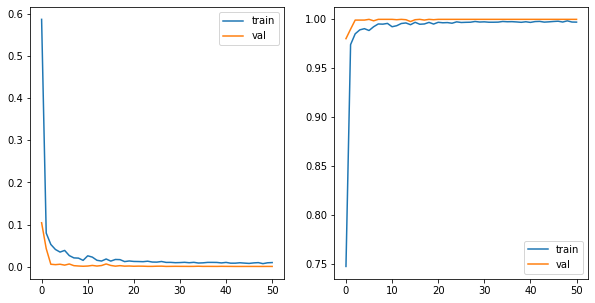

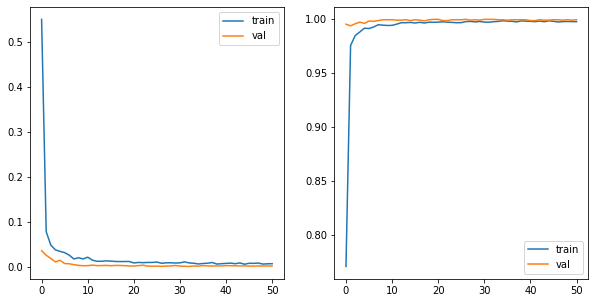

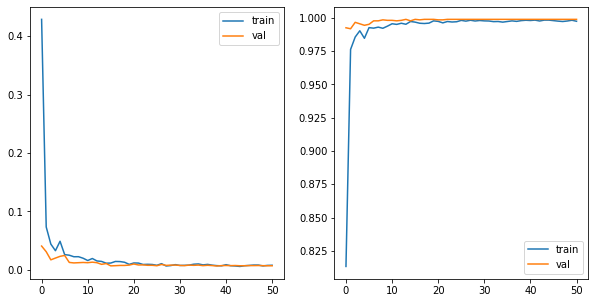

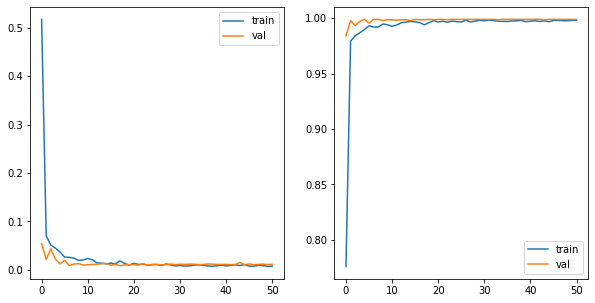

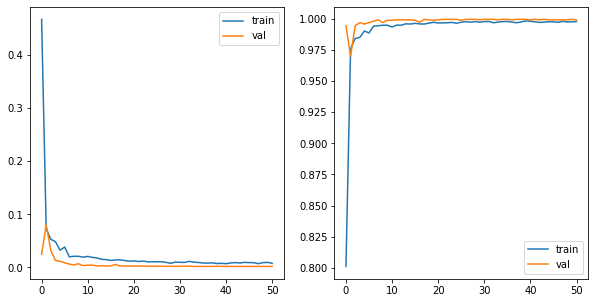

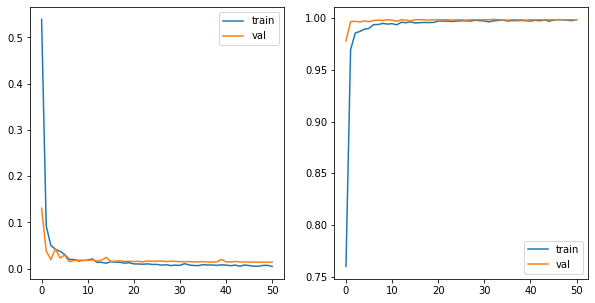

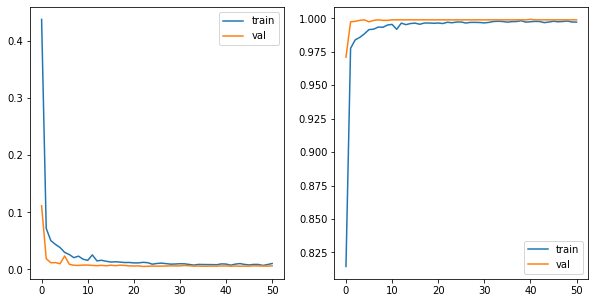

In [9]:
%%time
dict_pred = defaultdict(list)
file_names = []
for line in test_dataset.imgs:
    file_names.append(str(line).split('/')[-1].split('.')[0])

dict_pred['id'] = file_names

for i in trange(7):
    set_seed(SEED+i)
    
    train_type_loader, val_type_loader = load_split_train_valid(datadir=train_type_dir,                                                              
                                                              batch_size=BATCH_SIZE,
                                                              train_transforms=train_transforms,
                                                              valid_transforms=testval_transforms,
                                                              valid_size = .2)
    
    net = CNNc2()
    net = net.to(device)
    
    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)
    hystory_loss_train, hystory_loss_val, hystory_acc_train, hystory_acc_val =\
    train_model(net, loss, optimizer, scheduler, EPOCHS, train_nrj_loader, val_nrj_loader);
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.plot(hystory_loss_train, label='train')
    ax1.plot(hystory_loss_val, label='val')
    ax1.legend()

    ax2.plot(hystory_acc_train, label='train')
    ax2.plot(hystory_acc_val, label='val')
    ax2.legend()
    
    net.eval()
    dict_pred[f'CNNc2-{i}'] = []
    with torch.no_grad():
        for _, (img, name) in enumerate(tqdm(test_loader)):
            img = img.to(device)
            outputs = net(img)
            _, predicted = torch.max(outputs.data, dim=1)
            predicted = list(map(int, predicted.cpu()))
            dict_pred[f'CNNc2-{i}'].extend(predicted)

    del net
    torch.cuda.empty_cache()

In [10]:
data_frame = pd.DataFrame.from_dict(dict_pred)
data_frame.head()

,id,CNNc6-0,CNNc6-1,CNNc6-2,CNNc6-3,CNNc6-4,CNNc6-5,CNNc6-6
0,private_test\\00013a94f1fae3e5a33f8b44c2842c85...,3,3,3,3,3,3,1
1,private_test\\0005564c011259402dcb6e3beb6e64d2...,4,4,4,4,4,4,4
2,private_test\\0007520c8d8efade8feaafbf74fc7d20...,4,4,4,4,4,4,4
3,private_test\\000804a189f630cd980ff1543c0ef99d...,0,0,0,0,0,0,0
4,private_test\\000eb12def5371089743dcfe401a8e39...,4,4,4,2,4,2,4


In [11]:
data_frame['CNNc2-0'] = data_frame['CNNc2-0'].replace({
    0: 1.0, 
    1: 10.0,
    2: 20.0,
    3: 3.0,
    4: 30.0, 
    5: 6.0})
data_frame['CNNc2-1'] = data_frame['CNNc2-1'].replace({
    0: 1.0, 
    1: 10.0,
    2: 20.0,
    3: 3.0,
    4: 30.0, 
    5: 6.0})
data_frame['CNNc2-2'] = data_frame['CNNc2-2'].replace({
    0: 1.0, 
    1: 10.0,
    2: 20.0,
    3: 3.0,
    4: 30.0, 
    5: 6.0})
data_frame['CNNc2-3'] = data_frame['CNNc2-3'].replace({
    0: 1.0, 
    1: 10.0,
    2: 20.0,
    3: 3.0,
    4: 30.0, 
    5: 6.0})
data_frame['CNNc2-4'] = data_frame['CNNc2-4'].replace({
    0: 1.0, 
    1: 10.0,
    2: 20.0,
    3: 3.0,
    4: 30.0, 
    5: 6.0})
data_frame['CNNc2-5'] = data_frame['CNNc2-5'].replace({
    0: 1.0, 
    1: 10.0,
    2: 20.0,
    3: 3.0,
    4: 30.0, 
    5: 6.0})
data_frame['CNNc2-6'] = data_frame['CNNc2-6'].replace({
    0: 1.0, 
    1: 10.0,
    2: 20.0,
    3: 3.0,
    4: 30.0, 
    5: 6.0})

In [12]:
data_frame['id'] = data_frame['id'].apply(lambda x: x.split('\\\\')[1])
data_frame.head()

,id,CNNc6-0,CNNc6-1,CNNc6-2,CNNc6-3,CNNc6-4,CNNc6-5,CNNc6-6
0,00013a94f1fae3e5a33f8b44c2842c85f0483e96,3.0,3.0,3.0,3.0,3.0,3.0,10.0
1,0005564c011259402dcb6e3beb6e64d285124fa0,30.0,30.0,30.0,30.0,30.0,30.0,30.0
2,0007520c8d8efade8feaafbf74fc7d206cdf229d,30.0,30.0,30.0,30.0,30.0,30.0,30.0
3,000804a189f630cd980ff1543c0ef99d48cd6b34,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,000eb12def5371089743dcfe401a8e399f5883fc,30.0,30.0,30.0,20.0,30.0,20.0,30.0


In [13]:
data_frame.to_csv('CNNc6.csv', index=False, header=True)